In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

### Testing

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[...,
                                                           np.newaxis] / 255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

classes = np.unique(y_train)

#split and store images by class 
class_images = {}
for i in classes:
    class_images[i] = x_train[y_train == i]

Number of original training examples: 60000
Number of original test examples: 10000


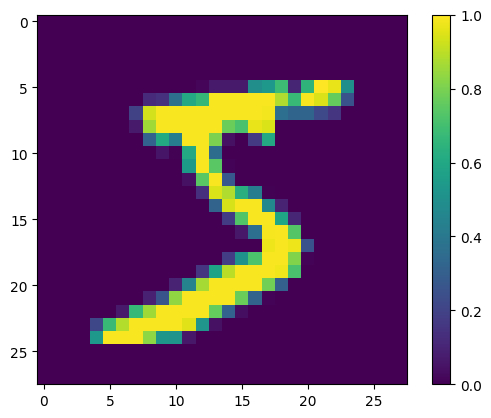

In [16]:

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

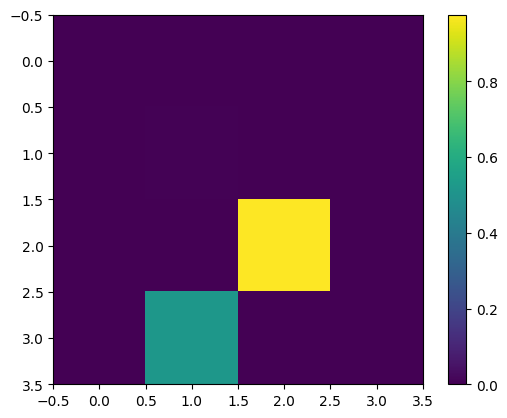

In [17]:
x_train_resize = tf.image.resize(x_train, (4, 4)).numpy()
x_test_resize = tf.image.resize(x_test, (4, 4)).numpy()

plt.imshow(x_train_resize[0, :, :, 0])
plt.colorbar()

### Normal Resizing

In [18]:
#normal resizing 
class_images_resized = {}

for e in class_images:
    imgs = []
    for img in class_images[e]:
        img = tf.image.resize(img, (4, 4)).numpy()
        img = img.squeeze().flatten()
        imgs.append(img.reshape(1, 16).squeeze())
    class_images_resized[e] = np.array(imgs)
    print(np.shape(imgs))


(5923, 16)
(6742, 16)
(5958, 16)
(6131, 16)
(5842, 16)
(5421, 16)
(5918, 16)
(6265, 16)
(5851, 16)
(5949, 16)


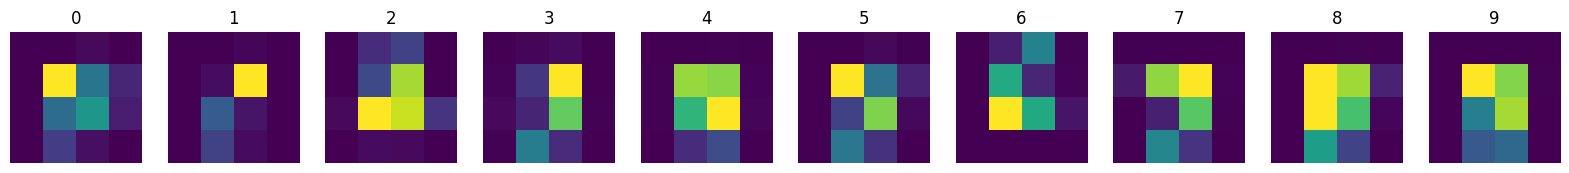

In [19]:
#average image and least similar image finding 

average_images_resizing = {}

for e in class_images_resized:
    average_images_resizing[e] = np.mean(class_images_resized[e], axis=0)



#plotting the average images 
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(average_images_resizing[i].reshape(4,4))
    ax[i].axis("off")
    ax[i].set_title(str(i))
plt.show()      

In [20]:
cosine_similarities_resizing = np.zeros((10, 10))

for i in range(10): 
    for j in range(10):
        cosine_similarities_resizing[i, j] = np.dot(average_images_resizing[i],average_images_resizing[j])/(np.linalg.norm(average_images_resizing[i])*np.linalg.norm(average_images_resizing[j]))


np.fill_diagonal(cosine_similarities_resizing, 0)
non_diagonal = cosine_similarities_resizing.flatten()
non_diagonal = non_diagonal[non_diagonal != 0]
print(np.min(non_diagonal))

indices = np.where(cosine_similarities_resizing == np.min(non_diagonal))
print(indices)




0.30924829840660095
(array([1, 6]), array([6, 1]))


In [21]:
vals = indices[0]
print(vals)
least_sim_class_images_resized = {}
least_sim_class_images_resized["6"] = class_images_resized[vals[0]]
least_sim_class_images_resized["7"] = class_images_resized[vals[1]]

print(np.shape(least_sim_class_images_resized["6"]))
print(np.shape(least_sim_class_images_resized["7"]))

train_resize_2class = np.concatenate((least_sim_class_images_resized["6"], least_sim_class_images_resized["7"]), axis=0)
#save data 
np.save("images_resize_class1_6.npy", train_resize_2class)

[1 6]
(6742, 16)
(5918, 16)


### Adaptive Pooling Downsampling

In [3]:
def downsample_image_ap(image):
    # image: (1, 28, 28) PyTorch tensor (assuming grayscale)
    return F.adaptive_avg_pool2d(image, (4, 4))

(1, 4, 4)


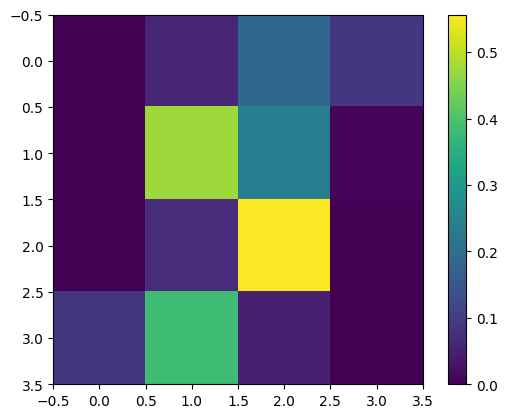

In [23]:
#adaptive pooling downsampling

sample_image = torch.tensor(x_train[0]).unsqueeze(0)
img = sample_image.reshape(1,28, 28)

x_train_ap = downsample_image_ap(img).numpy()

print(np.shape(x_train_ap))
plt.imshow(x_train_ap.squeeze())
plt.colorbar()


In [24]:
class_images_apd = {}

for entry in class_images:
    # Downsample image, remove batch dimension if present, then flatten
    imgs = []
    for j in class_images[entry]:
        img = torch.tensor(j).unsqueeze(0)
        img = img.reshape(1,28, 28) 
        img = downsample_image_ap(img).numpy().squeeze().flatten()
        imgs.append(img)
    class_images_apd[entry] = imgs
    print(np.shape(imgs))
    



(5923, 16)
(6742, 16)
(5958, 16)
(6131, 16)
(5842, 16)
(5421, 16)
(5918, 16)
(6265, 16)
(5851, 16)
(5949, 16)


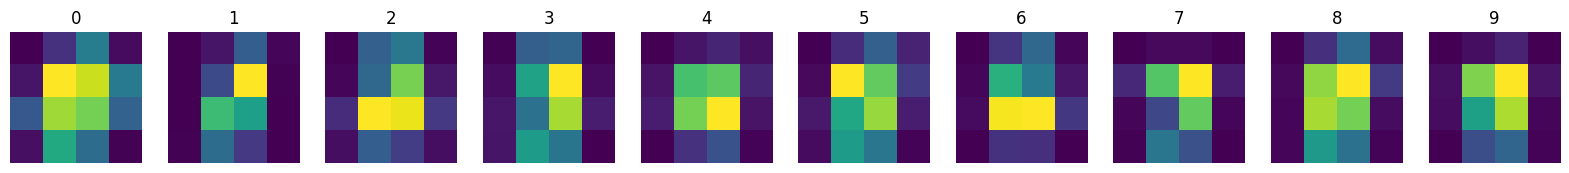

0.7637398530217495
(array([6, 7]), array([7, 6]))


In [25]:
#finding the average image for each class
average_images_apd = {}
for i in class_images_apd:
    average_images_apd[i] = np.mean(class_images_apd[i], axis=0)


#plotting the average images 
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(average_images_apd[i].reshape(4,4))
    ax[i].axis("off")
    ax[i].set_title(str(i))
plt.show()  

#find the 2 least similar images

cosine_similarities = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        cosine_similarities[i,j] = np.dot(average_images_apd[i], average_images_apd[j])/(np.linalg.norm(average_images_apd[i])*np.linalg.norm(average_images_apd[j]))

np.fill_diagonal(cosine_similarities, 0)


non_diagonal = cosine_similarities.flatten()
non_diagonal = non_diagonal[non_diagonal != 0]
print(np.min(non_diagonal))

indices = np.where(cosine_similarities == np.min(non_diagonal))
print(indices)


In [ ]:
vals = indices[0]
print(vals)
least_sim_class_images = {}
least_sim_class_images["6"] = class_images_apd[vals[0]]
least_sim_class_images["7"] = class_images_apd[vals[1]]

print(np.shape(least_sim_class_images["6"]))
print(np.shape(least_sim_class_images["7"]))

train_df_apd_2class = np.concatenate((least_sim_class_images["6"], least_sim_class_images["7"]), axis=0)
#save data 
np.save("X_apd_class6_7.npy", train_df_apd_2class)

# save the labels accordingly 
labels = np.array([6 if i <= np.shape(least_sim_class_images["6"])[0] else 7 for i in range(train_df_apd_2class.shape[0])])
np.save("y_apd_class6_7.npy", labels)

[6 7]
(5918, 16)
(6265, 16)


In [ ]:
import pandas as pd 

def preprocess_images(num_classes = 10, output_size = 4):

    def downsample_image_ap(image):
    # image: (1, 28, 28) PyTorch tensor (assuming grayscale)
        return F.adaptive_avg_pool2d(image, (output_size, output_size))

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[...,np.newaxis] / 255.0
    
    class_images_train = {}
    class_images_test = {}
    classes = np.unique(y_train)

    for i in classes:
        class_images_train[i] = x_train[y_train == i]
        class_images_test[i] = x_test[y_test == i]


    class_images_apd_train = {}
    class_images_apd_test = {}

    for c in classes:
        # Downsample image, remove batch dimension if present, then flatten
        train_imgs = []
        test_imgs = []
        for j in class_images_train[c]:
            img = torch.tensor(j).unsqueeze(0)
            img = img.reshape(1,28, 28) 
            img = downsample_image_ap(img).numpy().squeeze().flatten()
            train_imgs.append(img)
        class_images_apd_train[c] = train_imgs

        for k in class_images_test[c]:
            img = torch.tensor(k).unsqueeze(0)
            img = img.reshape(1,28, 28) 
            img = downsample_image_ap(img).numpy().squeeze().flatten()
            test_imgs.append(img)
        class_images_apd_test[c] = test_imgs
    

    final_x_train = []
    final_x_test = []
    
    final_y_train = []
    final_y_test = []

    for i in range(num_classes):
        final_x_train.append(class_images_apd_train[i])
        final_x_test.append(class_images_apd_test[i])
        
        final_y_train.append(np.full(len(class_images_apd_train[i]), i))  # Create labels for each class
        final_y_test.append(np.full(len(class_images_apd_test[i]), i))

    # Concatenate all class data and labels
    train_x = np.concatenate(final_x_train, axis=0)
    test_x = np.concatenate(final_x_test, axis=0)
    train_y = np.concatenate(final_y_train, axis=0)
    test_y = np.concatenate(final_y_test, axis=0)

    print(len(train_x))
    print(len(test_x))

    print(len(train_y))
    print(len(test_y))

        
    return train_x, test_x, train_y, test_y


trainX,testX,trainy,testy = preprocess_images(num_classes = 10, output_size = 4)



60000
10000
60000
10000


In [ ]:
print(np.shape(trainX))
print(np.shape(testX))
print(np.shape(trainy))
print(np.shape(testy))


(60000, 16)
(10000, 16)
(60000,)
(10000,)


In [21]:
np.save("train_X.npy", trainX)
np.save("train_y.npy", trainy)
np.save("test_X.npy", testX)
np.save("test_y.npy", testy)